In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy import integrate
from scipy import linalg
from scipy import interpolate
from sklearn import gaussian_process as gp
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Gaussian Random Field
class GaussianRandomField(object):
    def __init__(self, begin=0, end=1, kernel="RBF", length_scale=1, N=1000, interp="cubic"):
        self.N = N
        self.interp = interp
        self.x = np.linspace(begin, end, num=N)[:, None]
        if kernel == "RBF":
            K = gp.kernels.RBF(length_scale=length_scale)
        elif kernel == "AE":
            K = gp.kernels.Matern(length_scale=length_scale, nu=0.5)
        self.K = K(self.x)
        self.L = np.linalg.cholesky(self.K + 1e-13 * np.eye(self.N))

    def random(self, n):
        u = np.random.randn(self.N, n)
        return np.dot(self.L, u).T

    def eval_u_one(self, y, x):
        if self.interp == "linear":
            return np.interp(x, np.ravel(self.x), y)
        f = interpolate.interp1d(
            np.ravel(self.x), y, kind=self.interp, copy=False, assume_sorted=True
        )
        return f(x)

    def eval_u(self, ys, sensors):
        if self.interp == "linear":
            return np.vstack([np.interp(sensors, np.ravel(self.x), y).T for y in ys])

        res = np.zeros((ys.shape[0],sensors.shape[0]))
        for i in range(ys.shape[0]):
            res[i,:] = interpolate.interp1d(np.ravel(self.x), ys[i], kind=self.interp, copy=False, assume_sorted=True)(sensors).T
        return res

#Gaussian Progress Regression
class GP_regression:
    def __init__(self, num_x_samples):
        self.observations = {"x": list(), "y": list()}
        self.num_x_samples = num_x_samples
        self.x_samples = np.linspace(0, 1.0, self.num_x_samples).reshape(-1, 1)
        
        self.mu = np.zeros_like(self.x_samples)
        self.cov = self.kernel(self.x_samples, self.x_samples)
        
    def update(self, observations):
        self.update_observation(observations)
        
        x = np.array(self.observations["x"]).reshape(-1, 1)
        y = np.array(self.observations["y"]).reshape(-1, 1)
        
        K11 = self.cov
        K22 = self.kernel(x, x)
        K12 = self.kernel(self.x_samples, x)
        K21 = self.kernel(x, self.x_samples)
        K22_inv = np.linalg.inv(K22 + 1e-8 * np.eye(len(x)))
        
        self.mu = K12.dot(K22_inv).dot(y)
        self.cov = self.kernel(self.x_samples, self.x_samples) - K12.dot(K22_inv).dot(K21)
        
    def visualize(self, num_gp_samples=3):
        gp_samples = np.random.multivariate_normal(
            mean=self.mu.ravel(), 
            cov=self.cov, 
            size=num_gp_samples)
        x_sample = self.x_samples.ravel()
        mu = self.mu.ravel()
        #uncertainty = 1.96 * np.sqrt(np.diag(self.cov))

        plt.figure()
        #plt.fill_between(x_sample, mu + uncertainty, mu - uncertainty, alpha=0.1)
        plt.plot(x_sample, mu, label='Mean')
        for i, gp_sample in enumerate(gp_samples):
            plt.plot(x_sample, gp_sample, lw=1, ls='-', label=f'Sample {i+1}')
            
        plt.plot(self.observations["x"], self.observations["y"], 'rx')
        #plt.legend()
        plt.grid()
        return gp_samples

    def update_observation(self, observations):
        for x, y in zip(observations["x"], observations["y"]):
            if x not in self.observations["x"]:
                self.observations["x"].append(x)
                self.observations["y"].append(y)
                
    @staticmethod
    def kernel(x1, x2, l=0.5, sigma_f=0.2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return sigma_f ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)



#Finite difference method for ordinary differential equations
def FD_ord(f,grid,eps):
    dim = grid.shape[-1]
    h = (grid[-1]-grid[0])/(dim-1)
    N = f.shape[0]
    
    res = np.zeros((N,dim))
    p = -(eps/(h**2))
    
    for k in range(N):
        U = np.zeros((dim-2,dim-2))
        
        r = 2*eps/(h**2)-grid[1]/h
        q = grid[1]/h-eps/(h**2)
        U[0,:2] = np.array([r,q])
        
        r = 2*eps/(h**2)-grid[dim-2]/h
        U[-1,-2:] = np.array([p,r])
        
        j = 0
        for i in range(1,dim-3):
            r = 2*eps/(h**2)-grid[i+1]/h
            q = grid[i+1]/h-eps/(h**2)
            U[i,j:j+3] = np.array([p,r,q])
            j += 1
        
        B = np.zeros(dim-2)
        B[:] = f[k,1:-1]
        B = B.T
        
        res[k,1:-1] = np.linalg.solve(U,B).flatten()
        
    return res

#generate random functions(1d) default dim=1001
def generate(samples=1000, begin=0, end=1, random_dim=101, out_dim=1001, length_scale=1,interp="cubic"):
    space = GaussianRandomField(begin, end, length_scale=length_scale, N=random_dim, interp=interp)
    features = space.random(samples)
    x_grid = np.linspace(begin, end, out_dim)
    x_data = space.eval_u(features, x_grid[:, None])
    return x_grid, x_data

#generate random functions(2d)
def generate_2d(d_1,d_2):
    res = np.zeros((d_2.shape[0],d_1.shape[0]))
    res[0] = d_1
    
    for i in range(1,d_2.shape[0]):
        res[i] = res[i-1]+(d_2[i]-d_2[i-1])
    return res

#Finite difference method for 2d singularly perturbed differential equations
def FD_2d(f,grid_1,grid_2,eps=1/2**5):
    dim_1 = grid_1.shape[0]
    dim_2 = grid_2.shape[0]
    h_1 = 1/(dim_1-1)
    h_2 = 1/(dim_2-1)
    
    p = -eps/(h_1**2)
    r = 2*eps/(h_1**2)+2*eps/(h_2**2)-1/h_1-1/h_2
    q = -eps/(h_1**2)+1/h_1
    o = -eps/(h_2**2)
    s = -eps/(h_2**2)+1/h_2
    
    res = np.zeros_like(f)
    U = np.zeros((dim_1-2,dim_1-2))
    U[0,:2] = np.array([r,q])
    U[-1,-2:] = np.array([p,r])
    
    j = 0
    for i in range(1,dim_1-3):
        U[i,j:j+3] = np.array([p,r,q])
        j += 1
        
    T = np.eye(dim_1-2)*o
    V = np.eye(dim_1-2)*s
    Z = np.zeros((dim_1-2,dim_1-2))
    
    A_blc = np.empty((dim_2-2,dim_2-2), dtype=object)
    for i in range(dim_2-2):
        for j in range(dim_2-2):
            if i==j:
                A_blc[i,j] = U
            elif i+1==j:
                A_blc[i,j] = V
            elif i-1==j:
                A_blc[i,j] = T
            else:
                A_blc[i,j] = Z
    A = np.vstack([np.hstack(A_i) for A_i in A_blc])
    
    B = np.zeros((dim_1-2,dim_2-2))
    B[:,:] = f[1:-1,1:-1]
        
    B = np.reshape(B,((dim_1-2)*(dim_2-2),1))
    sol = np.linalg.solve(A,B)
    sol = np.reshape(sol,(dim_1-2,dim_2-2))
    res[1:-1,1:-1] = sol
        
    return res

#Finite difference method for singularly perturbed differential equations with initial-boundary problems
def FD_ib(f,grid_1,grid_2,eps=1):
    b_1 = f[0]
    b_2 = f[-1]
    dim_1 = grid_1.shape[0]
    dim_2 = grid_2.shape[0]+1
    h_1 = 1/(dim_1-1)
    h_2 = 1/(dim_2-2)
    
    p = -eps/(h_1**2)
    r = 2*eps/(h_1**2)-1/h_1+1/h_2
    q = -eps/(h_1**2)+1/h_1
    o = -1/h_2
    s = 0
    
    res = np.zeros((dim_2-1,dim_1))
    res[0,:] = f[:]
    for i in range(dim_2-1):
        res[i,0] = f[0]
        res[i,-1] = f[-1]
    
    U = np.zeros((dim_1-2,dim_1-2))
    U[0,:2] = np.array([r,q])
    U[-1,-2:] = np.array([p,r])
    
    j = 0
    for i in range(1,dim_1-3):
        U[i,j:j+3] = np.array([p,r,q])
        j += 1
        
    T = np.eye(dim_1-2)*o
    V = np.eye(dim_1-2)*s
    Z = np.zeros((dim_1-2,dim_1-2))
    
    A_blc = np.empty((dim_2-2,dim_2-2), dtype=object)
    for i in range(dim_2-2):
        for j in range(dim_2-2):
            if i==j:
                A_blc[i,j] = U
            elif i+1==j:
                A_blc[i,j] = V
            elif i-1==j:
                A_blc[i,j] = T
            else:
                A_blc[i,j] = Z
    A = np.vstack([np.hstack(A_i) for A_i in A_blc])
    
    B = np.zeros((dim_2-2,dim_1-2))
    B[0,:] = f[1:-1]
    B = np.reshape(B,((dim_2-2)*(dim_1-2),1))*(-o)
    
    C = np.zeros((dim_2-2,dim_1-2))
    for i in range(dim_2-2):
        C[i,0] = f[0]
    C = np.reshape(C,((dim_2-2)*(dim_1-2),1))*(-p)
    
    D = np.zeros((dim_2-2,dim_1-2))
    for i in range(dim_2-2):
        D[i,-1] = f[-1]
    D = np.reshape(D,((dim_2-2)*(dim_1-2),1))*(-q)
    
    sol = np.linalg.solve(A,B+C+D)
    sol = np.reshape(sol,(dim_2-2,dim_1-2))
    res[1:,1:-1] = sol
        
    return res

#Finite difference method for multiple epsilons
def FD_multi_eps(f,grid):
    dim = grid.shape[-1]
    h = (grid[-1]-grid[0])/(dim-1)
    N = f.shape[0]
    
    res = np.zeros((N,dim))
    for k in range(N):
        eps = f[k,-1]
        p = eps/(h**2)
        r = -2*eps/(h**2)-1/h
        q = eps/(h**2)+1/h
        U = np.zeros((dim-2,dim-2))
        U[0,:2] = np.array([r,q])
        U[-1,-2:] = np.array([p,r])
        
        j = 0
        for i in range(1,dim-3):
            U[i,j:j+3] = np.array([p,r,q])
            j += 1
        
        B = np.zeros(dim-2)
        B[:] = f[k,1:-2]
        B[0] -= p*0
        B[-1] -= q*0
        B = B.T
        
        res[k,0] = 0
        res[k,1:-1] = np.linalg.solve(U,B).flatten()
        res[k,-1] = 0
    return res

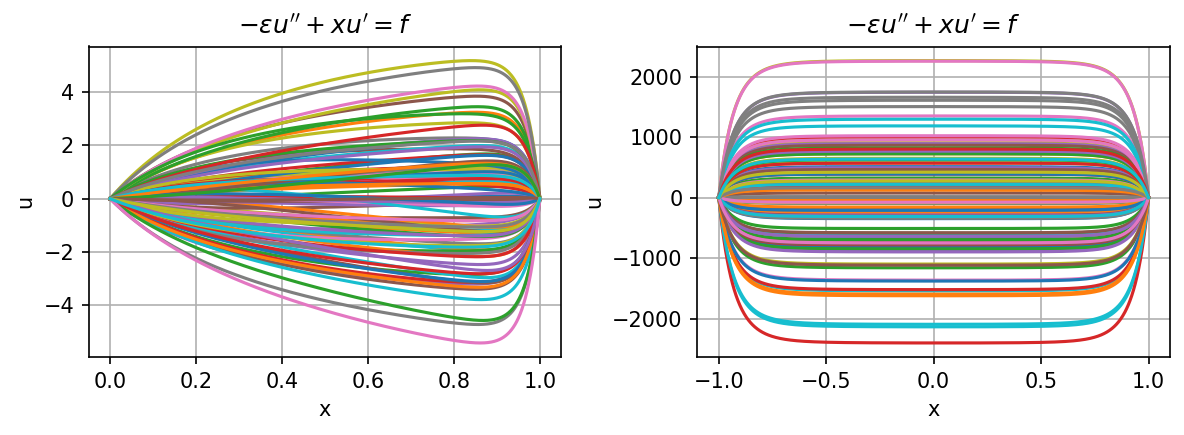

In [5]:
'''
ordinary differential equations,
1. -eu''+xu'=f, 0<x<1
2. -eu''+xu'=f, -1<x<1
'''
fig = plt.figure(figsize=(8,3),dpi=150)
#spde_no turning point
x_grid, x_data = generate()
y_data = FD_ord(x_data,x_grid,1/2**5)
np.save('data/spde_1_x.npy',x_data)
np.save('data/spde_1_y.npy',y_data)
plt.subplot(1,2,1)
for i in range(100):
    plt.title("$-\epsilon u''+xu'=f$")
    plt.plot(x_grid,y_data[i])
    plt.xlabel("x")
    plt.ylabel("u")
plt.grid()

#spde_turning point
x_grid, x_data = generate(begin=-1, end=1)
y_data = FD_ord(x_data,x_grid,1/2**4)
np.save('data/spde_2_x.npy',x_data)
np.save('data/spde_2_y.npy',y_data)
plt.subplot(1,2,2)
for i in range(100):
    plt.title("$-\epsilon u''+xu'=f$")
    plt.plot(x_grid,y_data[i])
    plt.xlabel("x")
    plt.ylabel("u")
plt.grid()

plt.tight_layout()
plt.show()
fig.savefig("img/ode_example.png")

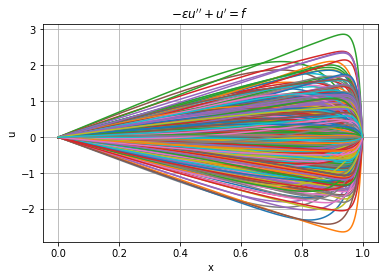

In [6]:
#mutiple epsilon situation
x_grid, x_data = generate()
eps = np.zeros((x_data.shape[0],1))
for i in range(x_data.shape[0]):
    if i<900:
        eps[i,0] = -(1/2**(i//(900//5)+2))
    else:
        eps[i,0] = -(1/2**(i%900//(100//5)+2))
x_data = np.concatenate((x_data,eps),-1)
y_data = FD_multi_eps(x_data,x_grid)
np.save('data/spde_mul_x.npy',x_data)
np.save('data/spde_mul_y.npy',y_data)
for i in range(1000):
    plt.title("$-\epsilon u''+u'=f$")
    plt.plot(x_grid,y_data[i])
    plt.xlabel("x")
    plt.ylabel("u")
plt.grid()
plt.show()

Generating y: 1000/1000

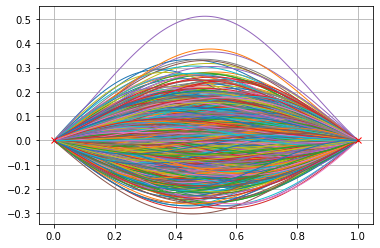

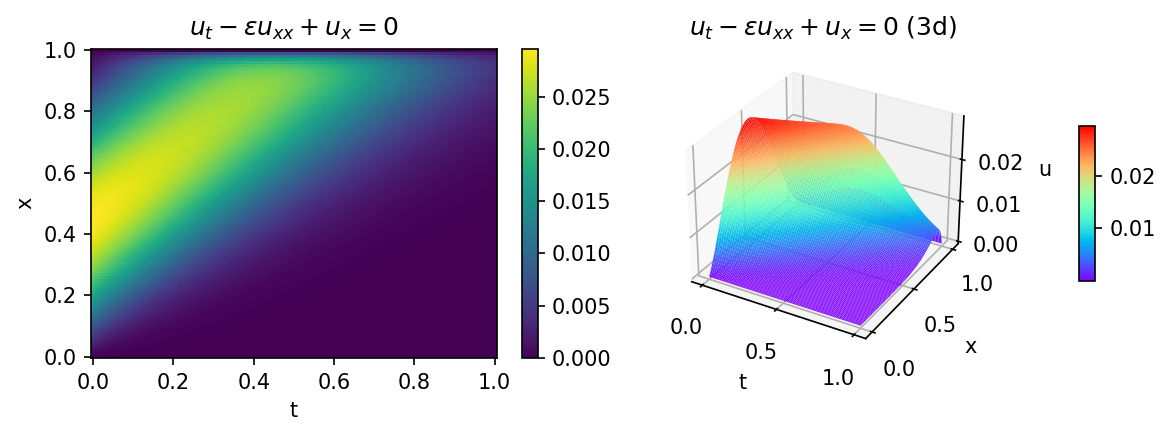

In [8]:
#spde_initial-boundary problem
gp1 = GP_regression(num_x_samples=101)
gp1.update({"x": [0, 1], "y": [0, 0]})
x_data = gp1.visualize(1000)

x_grid = np.linspace(0,1,101)
N = x_data.shape[0]
t_grid = x_grid
y_data = np.zeros((N,t_grid.shape[0],x_grid.shape[0]))
for i in range(N):
    x_data[i,0] = 0
    x_data[i,-1] = 0
    y_data[i] = FD_ib(x_data[i],x_grid,t_grid,1/2**5)
    print('\rGenerating y: {:d}/{:d}'.format(i+1,N), end='', flush=True)
    
X, T = np.meshgrid(x_grid, t_grid)
fig = plt.figure(figsize=(8,3),dpi=150)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("$u_t-\epsilon u_{xx}+u_x=0$")
im1 = ax1.pcolormesh(T, X, y_data[0], shading='auto')
ax1.set_xlabel("t")
ax1.set_ylabel("x")
fig.colorbar(im1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_title("$u_t-\epsilon u_{xx}+u_x=0$ (3d)")
surf = ax2.plot_surface(T,X,y_data[0],rstride=1,cstride=1,cmap=plt.get_cmap('rainbow'))
ax2.set_xlabel("t")
ax2.set_ylabel("x")
ax2.set_zlabel("u")
fig.colorbar(surf, shrink=0.5, aspect=10,pad=0.2)
plt.tight_layout()
plt.show()
fig.savefig("img/ib_example.png")

np.save('data/spde_ib_x.npy',x_data)
np.save('data/spde_ib_y.npy',y_data)

Generating y: 1000/1000

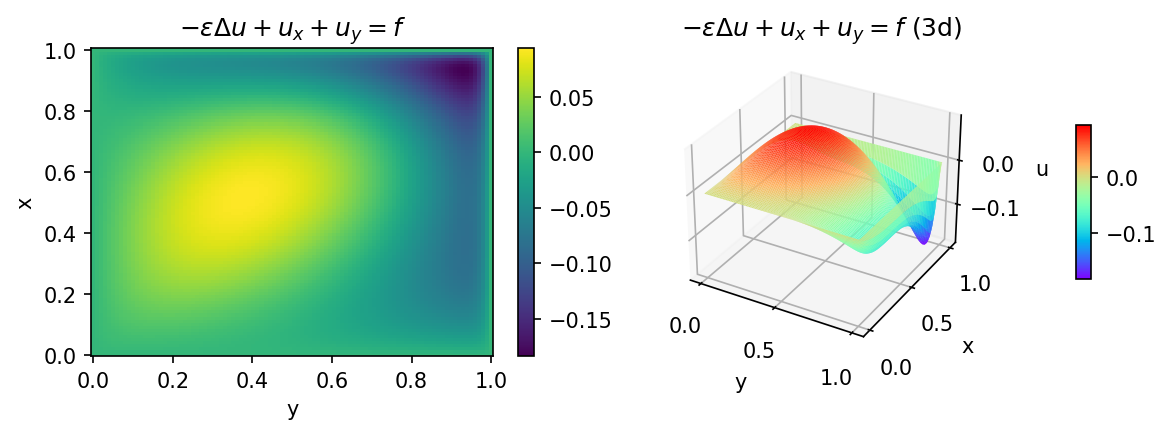

In [13]:
#spde_2d
x_grid, x_data = generate(samples=2*1000,out_dim=100)
N = x_data.shape[0]//2
res = np.zeros((N,x_grid.shape[0],x_grid.shape[0]))
y_data = np.zeros((N,x_grid.shape[0],x_grid.shape[0]))
for i in range(N):
    res[i] = generate_2d(x_data[i*2],x_data[i*2+1])
    y_data[i] = FD_2d(res[i],x_grid,x_grid)
    print('\rGenerating y: {:d}/{:d}'.format(i+1,N), end='', flush=True)

np.save('data/spde_2d_x.npy',res)
np.save('data/spde_2d_y.npy',y_data)

X, Y = np.meshgrid(x_grid, x_grid)
fig = plt.figure(figsize=(8,3),dpi=150)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("$-\epsilon \Delta u+u_x+u_y=f$")
im1 = ax1.pcolormesh(X, Y, y_data[0], shading='auto')
ax1.set_xlabel("y")
ax1.set_ylabel("x")
fig.colorbar(im1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_title("$-\epsilon \Delta u+u_x+u_y=f$ (3d)")
surf = ax2.plot_surface(X,Y,y_data[0],rstride=1,cstride=1,cmap=plt.get_cmap('rainbow'))
ax2.set_xlabel("y")
ax2.set_ylabel("x")
ax2.set_zlabel("u")
fig.colorbar(surf, shrink=0.5, aspect=10,pad=0.2)
plt.tight_layout()
plt.show()
fig.savefig("img/2d_example.png")